In [4]:
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from astropy.io import fits
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np
from spectres import spectres
from datetime import datetime
from matplotlib.pyplot import *
import time
import pickle
from matplotlib.pyplot import cm
from array import *
from astropy.io import fits
import glob
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
import matplotlib.pyplot as plt

# TODO:
### 1. Migrate plotting function into high res
### 2. Make tutorials

6.6804086158617375


/tmp/ipykernel_444022/568952216.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")


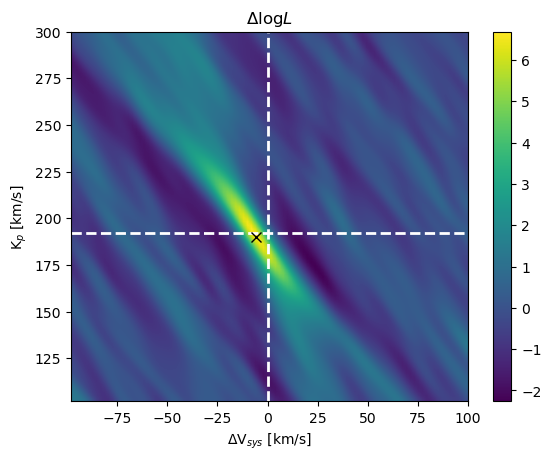

6.8315721302934715


/tmp/ipykernel_444022/568952216.py:95: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")


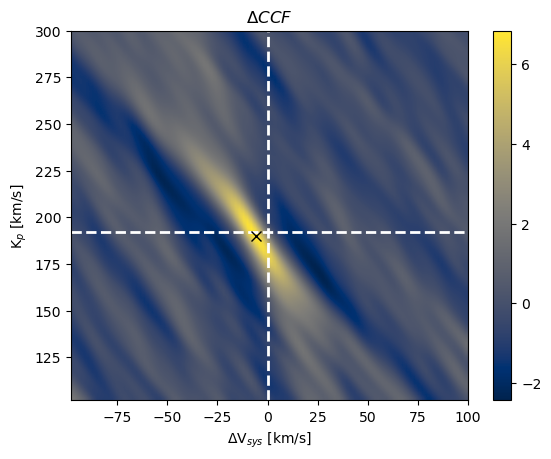

/tmp/ipykernel_444022/568952216.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_logL_slice.pdf", fmt="pdf")


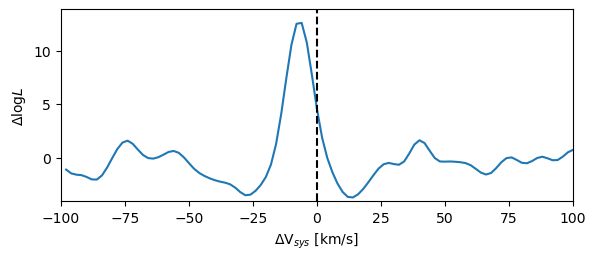

In [7]:
# output_path = "./CC_output/WASP-76b-injection-Na-7/"
# output_path = "./CC_output/WASP-121b/"
# output_path = "./CC_output/WASP-121b-injection/"
output_path = "./CC_output/WASP-77Ab/"
name = "WASP-77Ab"


K_p = 200  # True value 192.06
N_K_p = 100
d_K_p = 2
K_p_arr = (
    np.arange(N_K_p) - (N_K_p - 1) // 2
) * d_K_p + K_p  # making K_p_arr (centered on published or predicted K_p)
# K_p_arr = [92.06 , ..., 191.06, 192.06, 193.06, ..., 291.06]

V_sys = 0
N_V_sys = 100
d_V_sys = 2
V_sys_arr = (
    np.arange(N_V_sys) - (N_V_sys - 1) // 2
) * d_V_sys + V_sys  # making V_sys_arr (centered on published or predicted V_sys (here 0 because we already added V_sys in V_bary))

loglikelihood, CCF = pickle.load(
    open(output_path + "cross_correlation_results.pic", "rb")
)

# TODO: could use the following line after rerun (save K_p_arr, V_sys_arr)
# K_p_arr, V_sys_arr, loglikelihood, CCF = pickle.load(
#     open(output_path + "cross_correlation_results.pic", "rb")
# )

K_p = 192.06
V_sys = 0  # True value

stdev_range = (
    (V_sys_arr < V_sys - 15)
    | (V_sys_arr > V_sys + 15)
    | (K_p_arr < K_p - 15)
    | (K_p_arr > K_p + 15)
)  # [-40:, -40:] gives SNR = 15; Choose a box far from the planet velocity pair

loglikelihood = loglikelihood - np.mean(loglikelihood)
stdev = np.std(loglikelihood[stdev_range])
maxx = (loglikelihood / stdev).max()
print(maxx)
loc = np.where(loglikelihood / stdev == maxx)


fig, ax = subplots()
cax = ax.imshow(
    loglikelihood / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    interpolation="bilinear",
    origin="lower",
)

cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta $log$L$")

now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M")

savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()

# CCF
CCF = CCF - np.mean(CCF)
stdev = np.std(CCF[stdev_range])
maxx = (CCF / stdev).max()
print(maxx)
loc = np.where(CCF / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    CCF / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    interpolation="bilinear",
    cmap="cividis",
    origin="lower",
)
cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta CCF$")
savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()


# slice at Kp
index = np.argmin(np.abs(K_p_arr - K_p))
slicee = loglikelihood[index]
plot(V_sys_arr, slicee)
axis([-100, 100, 1.1 * slicee.min(), 1.1 * slicee.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("$\Delta$log$L$")
axvline(x=0, ls="--", color="black")
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path + name + "_logL_slice.pdf", fmt="pdf")
show()
close()